In [1]:
import os
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import vel
import vel.notebook as nb
nb.reasonable_notbook_defaults()
torch.set_grad_enabled(False)  # We don't need autograd here
None

In [3]:
config = nb.load_config('examples-configs/latent/mnist/mnist_fc_vae.yaml', run_number=1, device='cuda:0')

In [4]:
model = config.load_trained_model().to(config.device)

In [5]:
model.summary()

FcVae(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Reshape(sizes=(1, 28, 28), batch_dims=1)
    (6): Sigmoid()
  )
)
----------------------------------------------------------------------------------------------------
Number of model parameters: 425,284
----------------------------------------------------------------------------------------------------


In [6]:
data_loader = config.provide('loader')
data_source = data_loader.transformed_source
train_dataset = data_source.train
validation_dataset = data_source.validation

In [7]:
def get_sample(idx):
    return train_dataset[idx]['x'].to(config.device)

In [8]:
def show_image(axis, sample):
    axis.imshow(train_dataset.denormalize_item(sample, 'x'), cmap='gray')

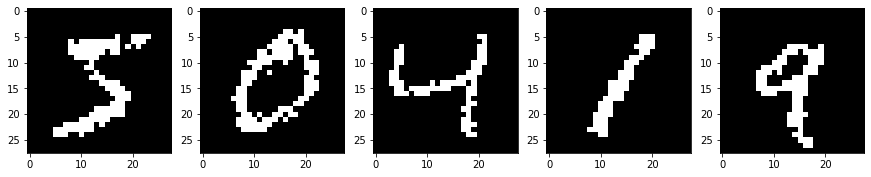

In [9]:
# Browse examples
fig, axes = plt.subplots(1, 5)

for index in range(5):
    show_image(axes[index], get_sample(index).cpu())

In [10]:
x = model.encode(get_sample(0)[None])
print(x)
print(x.shape)

tensor([[ 0.5881, -1.6104,  0.4107,  1.0962,  1.7997,  1.0594,  0.0516,  1.5038,
          2.1698,  0.0210, -0.3525,  0.4182,  1.5991,  0.0826,  1.5369,  0.0597,
          2.2284,  0.1273, -1.6312, -0.1385,  1.0510,  0.0295, -0.2376, -0.0673,
          0.5040,  0.7474, -0.1831,  0.7763,  0.1418,  1.6395, -2.4175,  0.7683,
          0.1352, -2.3757, -0.4010, -2.0714,  0.0345, -0.5530,  1.6734, -1.6953,
          2.1401,  1.4186,  0.7702,  0.0874, -0.8720, -1.3320, -1.0852, -0.1516,
         -1.0706,  1.0755]], device='cuda:0')
torch.Size([1, 50])


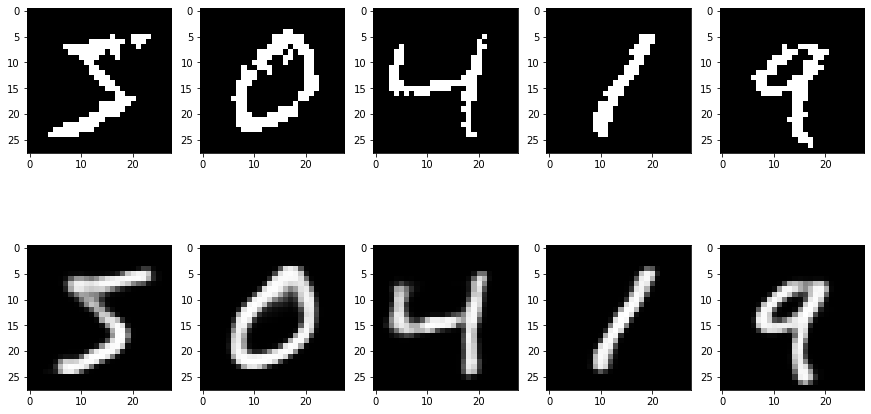

In [11]:
# Browse examples
fig, axes = plt.subplots(2, 5)

for index in range(5):
    sample = get_sample(index)
    decoded = model(sample[None])[0].detach()
    show_image(axes[0, index], sample.cpu())
    show_image(axes[1, index], decoded.cpu())

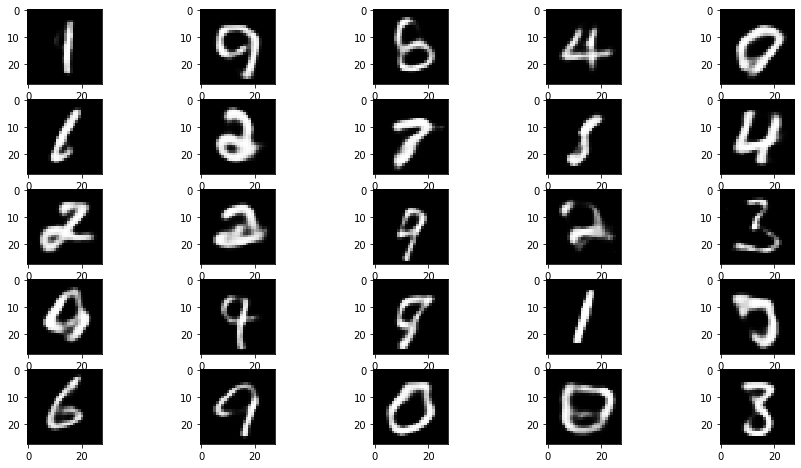

In [12]:
samples = torch.randn(5, 5, model.representation_length)

fig, axes = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        decoded = model.decode(samples[i, j][None].to(config.device))[0].detach()
        show_image(axes[i, j], decoded.cpu())

In [13]:
bs = 1_024

results = []

for i in tqdm.trange(validation_dataset.num_batches(bs)):
    nll = model.nll(validation_dataset.get_batch(i, bs)['x'].to(config.device))

    results.append(nll.cpu().numpy())


full_results = np.concatenate(results)

100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


In [14]:
np.mean(full_results)

90.79018

In [15]:
bs = 1_024

results = []

for i in tqdm.trange(validation_dataset.num_batches(bs)):
    nll = model.nll(validation_dataset.get_batch(i, bs)['x'].to(config.device), num_posterior_samples=5)

    results.append(nll.cpu().numpy())


full_results = np.concatenate(results)

100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


In [16]:
np.mean(full_results)

88.15819

In [17]:
bs = 1_024

results = []

for i in tqdm.trange(validation_dataset.num_batches(bs)):
    nll = model.nll(validation_dataset.get_batch(i, bs)['x'].to(config.device), num_posterior_samples=50)

    results.append(nll.cpu().numpy())


full_results = np.concatenate(results)

100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


In [18]:
np.mean(full_results)

87.12366

In [19]:
bs = 1_024

results = []

for i in tqdm.trange(validation_dataset.num_batches(bs)):
    nll = model.nll(validation_dataset.get_batch(i, bs)['x'].to(config.device), num_posterior_samples=500)

    results.append(nll.cpu().numpy())


full_results = np.concatenate(results)

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


In [20]:
np.mean(full_results)

86.84696

In [21]:
bs = 1_024

results = []

for i in tqdm.trange(validation_dataset.num_batches(bs)):
    nll = model.nll(validation_dataset.get_batch(i, bs)['x'].to(config.device), num_posterior_samples=2000)

    results.append(nll.cpu().numpy())


full_results = np.concatenate(results)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [22]:
np.mean(full_results)

86.82053

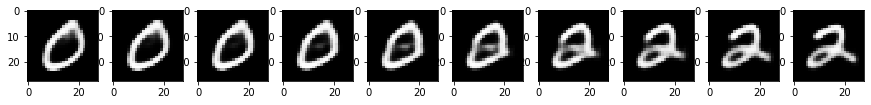

In [23]:
idx1 = 1
idx2 = 5

N = 10

encoding1 = model.encode(get_sample(idx1)[None])
encoding2 = model.encode(get_sample(idx2)[None])

fig, axes = plt.subplots(1, N)

for i in range(10):
    beta = float(i) / float(N - 1)
    alpha = 1.0 - beta
    
    combined =  model.decoder(encoding1 * alpha + encoding2 * beta)[0]
    
    show_image(axes[i], combined.cpu())